In [1]:
from google.colab import drive
! ls

gdrive	sample_data


In [0]:
# connect to Google drive
drive.mount('/content/gdrive/')

In [2]:
!ls gdrive/'My Drive'/DeepLearningProj

UCMerced_LandUse


In [3]:
# move to data directory
% cd gdrive/'My Drive'/DeepLearningProj/UCMerced_LandUse

/content/gdrive/My Drive/DeepLearningProj/UCMerced_LandUse


In [0]:
# import libraries
import os
import shutil
import random as rand

In [5]:
# list files
os.listdir()

['Images',
 'readme.txt',
 'readme.txt.bak',
 'TrainSet',
 'TestSet',
 'VGGTransferLearning.h5']

In [6]:
# look at number of labels and images for each
imgsource = "./Images"
labels = os.listdir(imgsource)
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print(num_classes, ':', num_imgs)

21 : [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [7]:
# check if train/test split needs to be generated
trainpath = "./TrainSet"
testpath = "./TestSet"
split = input("Generate train/test split? (y/n)\t")
if split.lower()=='y':
  split_into_train_test = True
else:
  split_into_train_test = False

Generate train/test split? (y/n)	n


In [0]:
# generate train/test split if 'y'
if split_into_train_test:
  os.makedirs(trainpath)
  os.makedirs(testpath)
  os.listdir()
  for fold in labels:
    split = rand.shuffle([True]*20+[False]*80)
    img_files = os.listdir(imgsource + '/' + fold)
    os.makedirs(trainpath + '/'+ fold)
    os.makedirs(testpath + '/'+ fold)
    for f in img_files:
      if split.pop():
        shutil.copyfile(imgsource + '/'+ fold + '/' + f, testpath + '/'+ fold + '/' + f)
      else:
        shutil.copyfile(imgsource + '/'+ fold + '/' + f, trainpath + '/'+ fold + '/' + f)

In [9]:
# look at number of labels and images for each train/test set
imgsource = trainpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Training set:\t', num_classes, ':', num_imgs)

imgsource = testpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Test set:\t', num_classes, ':', num_imgs)

print(labels)

Training set:	 21 : [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Test set:	 21 : [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
['tenniscourt', 'parkinglot', 'mobilehomepark', 'overpass', 'sparseresidential', 'river', 'storagetanks', 'runway', 'freeway', 'intersection', 'chaparral', 'harbor', 'mediumresidential', 'forest', 'golfcourse', 'buildings', 'beach', 'agricultural', 'airplane', 'baseballdiamond', 'denseresidential']


In [10]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


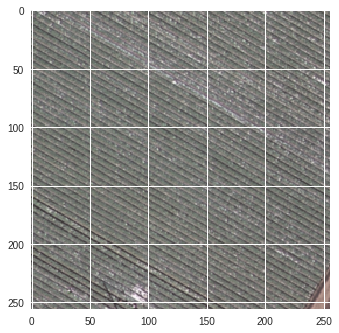

In [11]:
# display an image from training data
#! ls TrainSet/agricultural/	 
plt.imshow(load_img("./TrainSet/agricultural/agricultural01.tif"))
plt.show()

In [12]:
# build image generators for models
path_train_data = "./TrainSet/"
path_test_data = "./TestSet/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        class_mode='categorical')

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [32]:
# build CNN with transfer learning using VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(21, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_8 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fix base weights
conv_base.trainable = False
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(32768, 256) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 21) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(21,) dtype=float32_ref>]

In [0]:
# compile model
model.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [16]:
# train model
# ~10 minutes to run when not busy
transfer_learning_mod = model.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)

Epoch 1/5
100/100 [==============================] - 557s 6s/step - loss: 1.0147 - acc: 0.7300 - val_loss: 0.5219 - val_acc: 0.8353
Epoch 2/5
100/100 [==============================] - 202s 2s/step - loss: 0.2410 - acc: 0.9417 - val_loss: 0.3856 - val_acc: 0.8724
Epoch 3/5
100/100 [==============================] - 206s 2s/step - loss: 0.1108 - acc: 0.9743 - val_loss: 0.2500 - val_acc: 0.9069
Epoch 4/5
100/100 [==============================] - 206s 2s/step - loss: 0.0589 - acc: 0.9880 - val_loss: 0.3149 - val_acc: 0.8767
Epoch 5/5
100/100 [==============================] - 206s 2s/step - loss: 0.0366 - acc: 0.9920 - val_loss: 0.2345 - val_acc: 0.9218


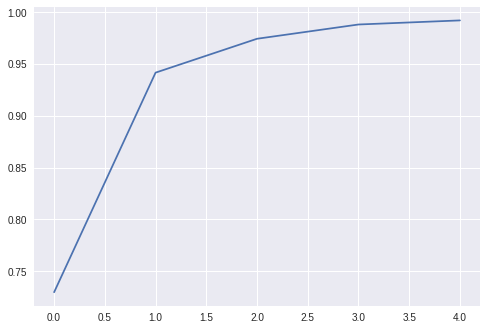

In [17]:
# plot training accuracies
plt.plot(transfer_learning_mod.history["acc"])
plt.show()

In [0]:
# save weights
#model.save_weights('VGGTransferLearning.h5')
# load model weights
#model.load_weights('VGGTransferLearning.h5')

In [19]:
# look at labels of the test set
print(test_generator.class_indices)
class_labels = {}
# switch key and values for class labels
for k, v in test_generator.class_indices.items():
  class_labels[str(v)]=k
print(class_labels)

{'tenniscourt': 0, 'parkinglot': 1, 'mobilehomepark': 2, 'overpass': 3, 'sparseresidential': 4, 'river': 5, 'storagetanks': 6, 'runway': 7, 'freeway': 8, 'intersection': 9, 'chaparral': 10, 'harbor': 11, 'mediumresidential': 12, 'forest': 13, 'golfcourse': 14, 'buildings': 15, 'beach': 16, 'agricultural': 17, 'airplane': 18, 'baseballdiamond': 19, 'denseresidential': 20}
{'0': 'tenniscourt', '1': 'parkinglot', '2': 'mobilehomepark', '3': 'overpass', '4': 'sparseresidential', '5': 'river', '6': 'storagetanks', '7': 'runway', '8': 'freeway', '9': 'intersection', '10': 'chaparral', '11': 'harbor', '12': 'mediumresidential', '13': 'forest', '14': 'golfcourse', '15': 'buildings', '16': 'beach', '17': 'agricultural', '18': 'airplane', '19': 'baseballdiamond', '20': 'denseresidential'}


In [0]:
# build functions to look at misclassifications
def display(misclass):
  plt.figure(figsize=(15, 10))

  n = int(np.ceil(np.sqrt(len(misclass))))
  ind = 1
  for y, yhat, x in misclass:
    plt.subplot(n, n, ind)  
    plt.grid(False)
    plt.axis('off')
    plt.text(.5, .5, y+'->\n'+yhat, fontsize=9, color='red')
    plt.imshow(x)
    ind +=1
  plt.show()

def eval_model(model, img_gen):
  
  ind = 1
  
  misclass = []
  
  for i in range(len(img_gen)):
    xs, ys = img_gen.next()
    ys = [class_labels[str(np.argmax(l))]  for l in ys]
    yhats = model.predict(xs)
    yhats = [class_labels[str(np.argmax(p))] for p in yhats]
    
    for y, yhat, x in (list(zip(ys, yhats, xs))):
      if y != yhat:
        misclass.append((y, yhat, x))
  display(misclass)
  misclass = [y+'->'+yhat for y, yhat, x in misclass]
  [print(cnt) for cnt in Counter(misclass).most_common()]

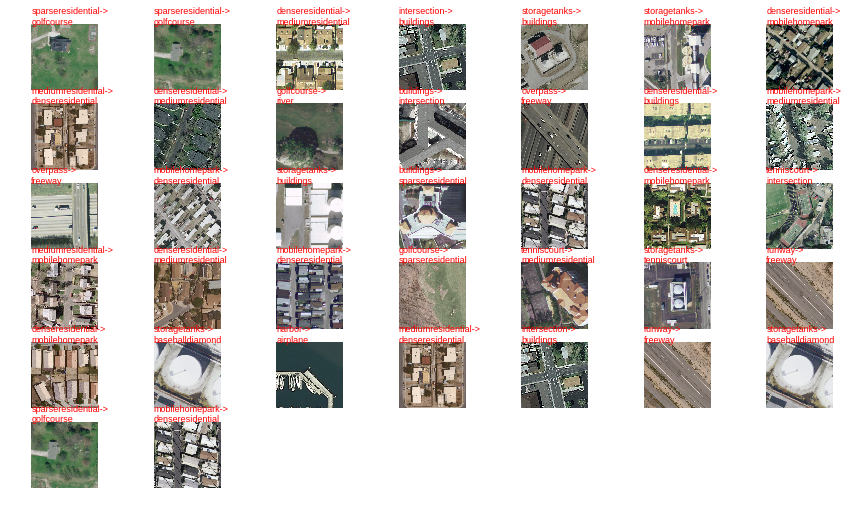

('mobilehomepark->denseresidential', 4)
('sparseresidential->golfcourse', 3)
('denseresidential->mediumresidential', 3)
('denseresidential->mobilehomepark', 3)
('intersection->buildings', 2)
('storagetanks->buildings', 2)
('mediumresidential->denseresidential', 2)
('overpass->freeway', 2)
('runway->freeway', 2)
('storagetanks->baseballdiamond', 2)
('storagetanks->mobilehomepark', 1)
('golfcourse->river', 1)
('buildings->intersection', 1)
('denseresidential->buildings', 1)
('mobilehomepark->mediumresidential', 1)
('buildings->sparseresidential', 1)
('tenniscourt->intersection', 1)
('mediumresidential->mobilehomepark', 1)
('golfcourse->sparseresidential', 1)
('tenniscourt->mediumresidential', 1)
('storagetanks->tenniscourt', 1)
('harbor->airplane', 1)


In [21]:
# look at misclassifications
eval_model(model, test_generator)

In [0]:
del model

In [35]:
# build another CNN with transfer learning using VGG16
model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dense(21, activation="sigmoid"))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_10 (Dense)             (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [36]:
# have static base weights
conv_base.trainable = True
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_10 (Dense)             (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
model2.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [38]:
# train model
# ~30 minutes to run
transfer_learning_mod2 = model2.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)

Epoch 1/5
100/100 [==============================] - 427s 4s/step - loss: 2.2747 - acc: 0.3062 - val_loss: 0.7559 - val_acc: 0.7603
Epoch 2/5
100/100 [==============================] - 424s 4s/step - loss: 0.6474 - acc: 0.8009 - val_loss: 0.3592 - val_acc: 0.8622
Epoch 3/5
100/100 [==============================] - 423s 4s/step - loss: 0.3085 - acc: 0.9126 - val_loss: 0.3026 - val_acc: 0.9129
Epoch 4/5
100/100 [==============================] - 423s 4s/step - loss: 0.1849 - acc: 0.9484 - val_loss: 0.3138 - val_acc: 0.9302
Epoch 5/5
100/100 [==============================] - 425s 4s/step - loss: 0.1477 - acc: 0.9638 - val_loss: 0.3721 - val_acc: 0.9190


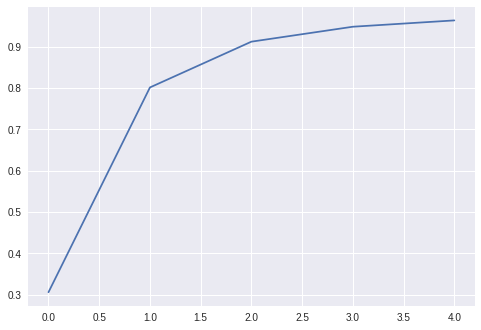

In [39]:
# plot training accuracies
plt.plot(transfer_learning_mod2.history["acc"])
plt.show()

In [0]:
# save weights
model2.save_weights('VGGTransferLearning2.h5')
# load model weights
# model2.load_weights('VGGTransferLearning2.h5')

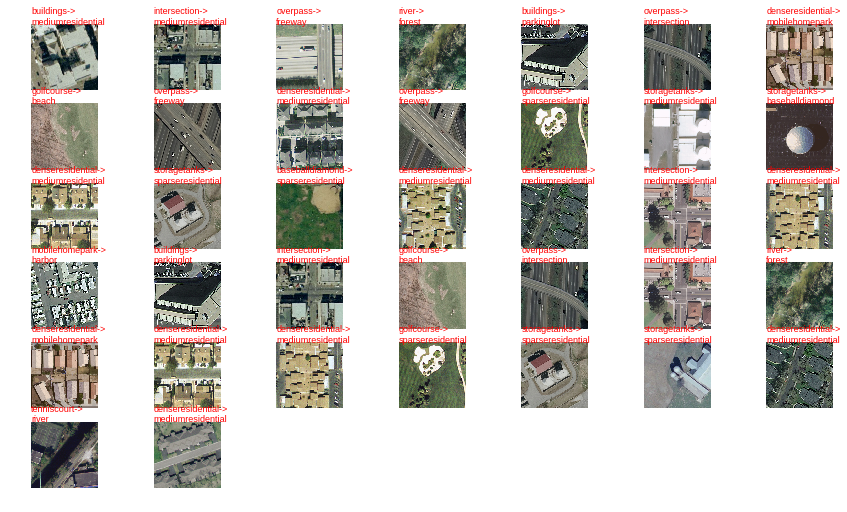

('denseresidential->mediumresidential', 9)
('intersection->mediumresidential', 4)
('overpass->freeway', 3)
('storagetanks->sparseresidential', 3)
('river->forest', 2)
('buildings->parkinglot', 2)
('overpass->intersection', 2)
('denseresidential->mobilehomepark', 2)
('golfcourse->beach', 2)
('golfcourse->sparseresidential', 2)
('buildings->mediumresidential', 1)
('storagetanks->mediumresidential', 1)
('storagetanks->baseballdiamond', 1)
('baseballdiamond->sparseresidential', 1)
('mobilehomepark->harbor', 1)
('tenniscourt->river', 1)


In [41]:
# look at misclassifications
eval_model(model2, test_generator)

In [0]:
del model2

In [51]:
# build a CNN from scratch without transfer learning
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(256, 256, 3)))
model3.add(Conv2D(filters = 32, kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model3.add(MaxPooling2D(pool_size=(5,5)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(21, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 255, 255, 32)      416       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 252, 252, 32)      16416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               20480256  
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
__________

In [0]:
# compile model
model3.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [53]:
# ~15 minutes to run
training_mod = model3.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)

Epoch 1/5
100/100 [==============================] - 180s 2s/step - loss: 2.9608 - acc: 0.1079 - val_loss: 2.7665 - val_acc: 0.1621
Epoch 2/5
100/100 [==============================] - 176s 2s/step - loss: 2.7175 - acc: 0.1785 - val_loss: 2.5501 - val_acc: 0.2750
Epoch 3/5
100/100 [==============================] - 176s 2s/step - loss: 2.5511 - acc: 0.2274 - val_loss: 2.3464 - val_acc: 0.3496
Epoch 4/5
100/100 [==============================] - 177s 2s/step - loss: 2.4107 - acc: 0.2693 - val_loss: 2.2287 - val_acc: 0.3759
Epoch 5/5
100/100 [==============================] - 177s 2s/step - loss: 2.2625 - acc: 0.3213 - val_loss: 2.0625 - val_acc: 0.4259


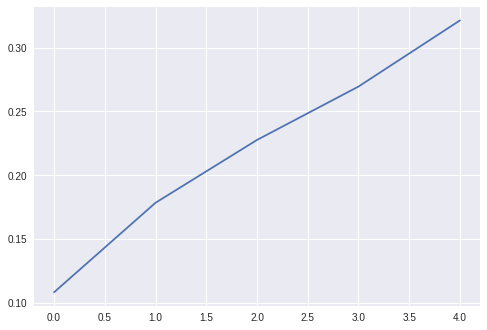

In [54]:
# plot training accuracy
plt.plot(training_mod.history["acc"])
plt.show()

In [55]:
# train some more
# ~15 minutes to run
training_mod = model3.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)

Epoch 1/5
100/100 [==============================] - 181s 2s/step - loss: 2.1348 - acc: 0.3573 - val_loss: 1.9684 - val_acc: 0.4336
Epoch 2/5
100/100 [==============================] - 180s 2s/step - loss: 2.0230 - acc: 0.3830 - val_loss: 1.8180 - val_acc: 0.4862
Epoch 3/5
100/100 [==============================] - 181s 2s/step - loss: 1.8966 - acc: 0.4201 - val_loss: 1.7487 - val_acc: 0.4840
Epoch 4/5
100/100 [==============================] - 179s 2s/step - loss: 1.8150 - acc: 0.4473 - val_loss: 1.7515 - val_acc: 0.4776
Epoch 5/5
100/100 [==============================] - 179s 2s/step - loss: 1.7166 - acc: 0.4798 - val_loss: 1.7011 - val_acc: 0.4629


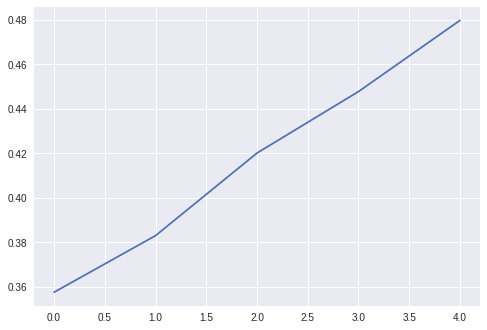

In [56]:
# plot training accuracy
plt.plot(training_mod.history["acc"])
plt.show()

In [57]:
# train some more
# ~15 minutes to run
training_mod = model3.fit_generator(train_generator, steps_per_epoch=100, epochs=30, 
                                            validation_data=test_generator, validation_steps=25)

Epoch 1/30
100/100 [==============================] - 182s 2s/step - loss: 1.6326 - acc: 0.5037 - val_loss: 1.5427 - val_acc: 0.5276
Epoch 2/30
100/100 [==============================] - 180s 2s/step - loss: 1.5612 - acc: 0.5290 - val_loss: 1.4798 - val_acc: 0.5707
Epoch 3/30
100/100 [==============================] - 181s 2s/step - loss: 1.4859 - acc: 0.5473 - val_loss: 1.4871 - val_acc: 0.5908
Epoch 4/30
100/100 [==============================] - 180s 2s/step - loss: 1.4192 - acc: 0.5674 - val_loss: 1.4048 - val_acc: 0.5802
Epoch 5/30
100/100 [==============================] - 179s 2s/step - loss: 1.3430 - acc: 0.5903 - val_loss: 1.4372 - val_acc: 0.5681
Epoch 6/30
100/100 [==============================] - 180s 2s/step - loss: 1.2925 - acc: 0.6003 - val_loss: 1.4439 - val_acc: 0.5690
Epoch 7/30
100/100 [==============================] - 180s 2s/step - loss: 1.2381 - acc: 0.6148 - val_loss: 1.3023 - val_acc: 0.6008
Epoch 8/30
100/100 [==============================] - 180s 2s/step - 

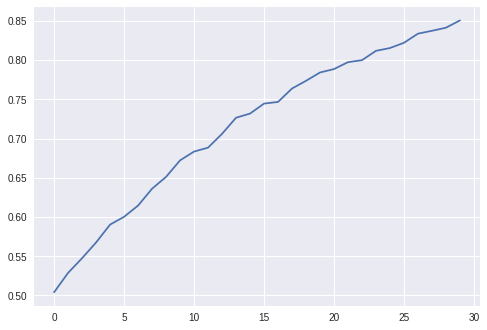

In [58]:
# plot training accuracy
plt.plot(training_mod.history["acc"])
plt.show()

In [0]:
# save weights
model3.save_weights('CNNmod3.h5')
# load model weights
# model3.load_weights('CNNmod3.h5')

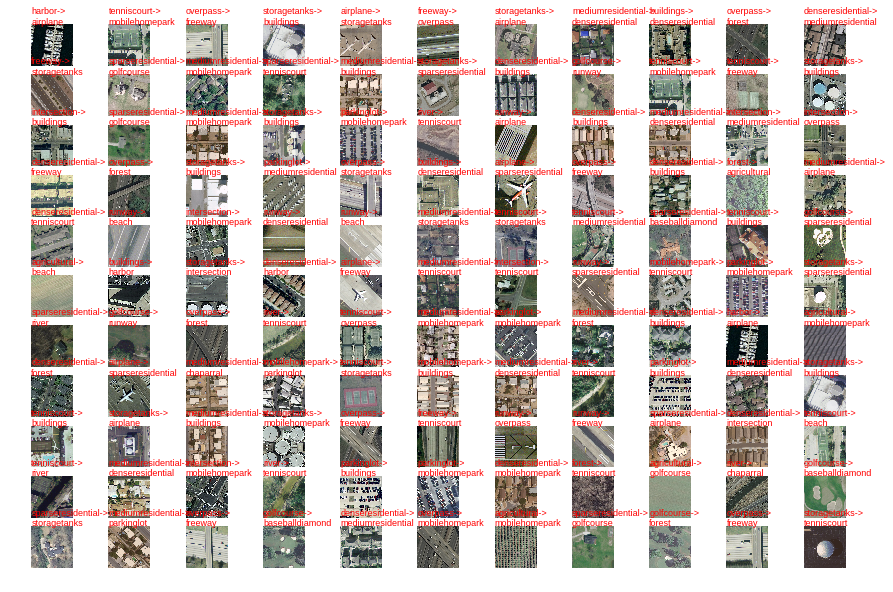

('overpass->freeway', 5)
('storagetanks->buildings', 5)
('mediumresidential->denseresidential', 5)
('denseresidential->buildings', 4)
('parkinglot->mobilehomepark', 4)
('river->tenniscourt', 4)
('overpass->forest', 3)
('sparseresidential->golfcourse', 3)
('mediumresidential->mobilehomepark', 3)
('harbor->airplane', 2)
('tenniscourt->mobilehomepark', 2)
('storagetanks->airplane', 2)
('buildings->denseresidential', 2)
('denseresidential->mediumresidential', 2)
('mediumresidential->buildings', 2)
('storagetanks->sparseresidential', 2)
('golfcourse->runway', 2)
('airplane->sparseresidential', 2)
('runway->beach', 2)
('intersection->mobilehomepark', 2)
('tenniscourt->storagetanks', 2)
('tenniscourt->buildings', 2)
('agricultural->mobilehomepark', 2)
('parkinglot->buildings', 2)
('golfcourse->baseballdiamond', 2)
('airplane->storagetanks', 1)
('freeway->overpass', 1)
('freeway->storagetanks', 1)
('sparseresidential->tenniscourt', 1)
('tenniscourt->freeway', 1)
('intersection->buildings', 1)


In [60]:
# look at misclassifications
eval_model(model3, test_generator)